## Learning how to use George

In [1]:
#We'll need some standard packages
import matplotlib.pyplot as plt
import numpy as np
import george as g

from scipy.optimize import minimize

I'll construct some test data. To begin with, I'm running through the example in the george docs.

In [2]:
# Test data
# np.random.seed(1234)
def f(x, yerr=None):
    if yerr is None: 
        yerr = np.zeros(x.shape)
    
    yo = np.sin(x) + yerr * np.random.randn(len(x))

    # yo = 0.5 * x + yerr*np.random.randn(len(x))

    return yo

xo = 10 * np.sort(np.random.rand(15))
yoerr = 0.2 * np.ones_like(xo)
yo = f(xo, yoerr)

# Initialise the GP object
print('Variance of y: {}'.format(np.var(yo)))

Variance of y: 0.612004564442927


Now, I need to initialise the GP object. First, I create a kernel with the same width as the variance of yo as my prior, and a timescale of 0.5:

In [3]:
# Specify a (stationary) kernel with the variance of yo, and a length scale of 0.5
kernel = np.var(yo) * g.kernels.ExpSquaredKernel(0.5)
print("Kernel has {} dimensions".format(kernel.ndim))
print("Kernel has {} parameter names".format(kernel.parameter_names))
for name in kernel.parameter_names:
    print('{:20}: {}'.format(name, kernel[name]))

Kernel has 1 dimensions
Kernel has ('k1:log_constant', 'k2:metric:log_M_0_0') parameter names
k1:log_constant     : -0.4910155382575468
k2:metric:log_M_0_0 : -0.6931471805599453


### Note on Kernels:
The kernel is stationary, meaning that it ignores the value of the 'time' axis, only using the distance from the last data point as its inputs. This is converse to non-stationary kernels, which account for the location on the x-axis when computing their stuff. As an example, the following is a non-stationary, local gaussian kernel:

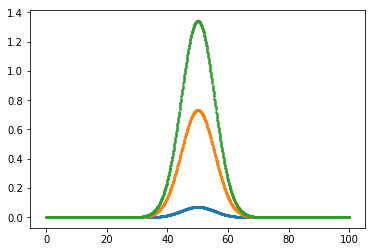

In [36]:
width = np.log(30)
eg = g.kernels.LocalGaussianKernel(location=50, log_width=width, ndim=1)
gp = g.GP(eg)

xp = np.arange(0, 100, 0.1)
yp = gp.sample(xp, 3)
for y in yp:
    plt.scatter(xp, y, s=3)
plt.show()

In [37]:
# Use that kernel to make a GP object
gp = g.GP(kernel)


# Pre-compute the covariance matrix and factorize it for a set of times and uncertainties.
gp.compute(xo, yoerr)
# This helps with speed later, and allows us to use the 'predict' function

In [38]:
# Define a prediction array of x values
xp = np.linspace(0, 10, 500)
# Use the GP to predict the values of y at these x
yp, yperr = gp.predict(yo, xp, return_var=True)

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(yo)))

Initial ln-likelihood: -7.63


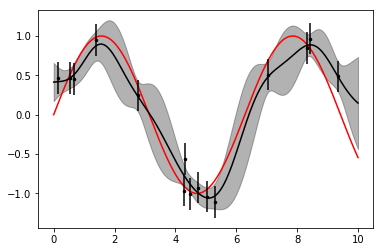

In [40]:
# Initialise plotting area
fig, ax = plt.subplots()

# Plot the actual form of the posterior
ax.plot(xp, f(xp), color='red', zorder=1)
# Plot the prediction variance
ax.fill_between(xp, yp+np.sqrt(yperr), yp-np.sqrt(yperr),
    alpha=0.3, color='black')
# Plot the prediction means
ax.plot(xp, yp, color='black')
# Plot the data
ax.errorbar(xo, yo, yoerr, markersize=5, fmt='.k', capsize=0)

plt.show()

You can see that the posterior is relatively well-modelled in general, but in between data the errors widen. This is what we want. 